## Evaluate.ipynb
#### **This notebook evaluates the accuracy of just one model on the IEMOCAP dataset ground truths.**

- **Transcription Model (S2T):** gemini-flash-1.5
- Source: Google

## Setup

In [1]:
# Run
SEED = 22
FOLD = 0

# Models
SENTIMENT_MODEL_NAME = 'models/gemini-1.5-flash'

# Flag to enable parsing of arguments when converted to script. Set true after converting
PYTHON_SCRIPT = False

### For Conversion to .py file

In [2]:
if PYTHON_SCRIPT:

    import argparse

    parser = argparse.ArgumentParser(description="")
    parser.add_argument('--seed',default=2021,type=int)
    parser.add_argument('--fold',type=int,required=True)
    parser.add_argument('--remap',type=bool,required=True)
    parser.add_argument('--threshold',type=float,required=False)
    parser.add_argument('--mode',required=False)
    parser.add_argument('--flip',type=bool,required=False)

    # Parse the arguments
    args = parser.parse_args()

    # Run
    SEED = args.seed
    FOLD = args.fold
    RUN_REMAP = args.remap
    THRESHOLD = args.threshold
    MODE = args.mode
    FLIP = args.flip

## Folders

In [3]:
# Filepaths
OUTPUT_FOLDER = f'./fold_{FOLD}'
LOG_OUTPUT = OUTPUT_FOLDER + f'/fold-{FOLD}.log'

### Dataset Setup

In [4]:
# Dataset
TSV = r'C:\Users\ChenYi\Downloads\AAI3001_Project\labels\IEMOCAP_4.tsv'
AUDIO_DIRECTORY = r'C:\Users\ChenYi\Downloads\AAI3001_Project\small-project\IEMOCAP_full_release_audio'

# Contains the correct transcription provided by the IEMOCAP dataset
GROUND_TRUTH = './groundtruth_IEMOCAP.csv'

# Contains the correct emotions (A, H, S, N) remapped to positive, negative and neutral
REMAPPED_EMOTIONS = './sentiment_truths_IEMOCAP.csv'

#### Select GPUs (For multi-GPU setup)

In [5]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Logger

In [6]:
import logging
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter("[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s")
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])

    fh = logging.FileHandler(filename, "w")
    fh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(fh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    sh = logging.StreamHandler()                                                                                                                                                                                   
    sh.setFormatter(formatter)                                                                                                                                                                                     
    logger.addHandler(sh)                                                                                                                                                                                          
                                                                                                                                                                                                                   
    return logger
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
logger = get_logger(LOG_OUTPUT)

### NLP Preprocessing Settings

In [7]:
APPLY_NLP_PREPROCESS = False
APPLY_CONTRACTIONS = True
APPLY_LEMMANTIZATION = True
APPLY_REMOVE_STOPWORDS = False
APPLY_REMOVE_NUMBERS = True  

### For Cloud Instances
Run the following to install required libraries

In [8]:
CLOUD = False

In [9]:
if CLOUD:
    !pip install contractions
    !pip install clean-text
    !pip install nltk
    !python -m spacy download en_core_web_sm

## Imports

In [10]:
import google.generativeai as genai
import pathlib
import csv
import torch
import random
import librosa
import torchaudio
import contractions
import torch.nn as nn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset, DatasetDict
from torchaudio import functional as audioF
from torchaudio.transforms import Resample
from torchaudio.compliance import kaldi
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report, recall_score, accuracy_score

# NLP Stuff
import spacy
import string
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm")
mapping = str.maketrans('', '', string.digits) # table to remove strings

[2025-01-12 20:38:14,579][config.py][line:54][INFO] PyTorch version 2.4.1+cu124 available.
[2025-01-12 20:38:14,582][config.py][line:101][INFO] TensorFlow version 2.18.0 available.


### Log Details

In [11]:
logger.info("----- Models -----")
logger.info(f"Sentiment Model: {SENTIMENT_MODEL_NAME}")
logger.info("----- Parameters -----")
logger.info(f"Seed: {SEED}")
logger.info(f"Fold: {FOLD}")

logger.info("----- NLP Options -----")
if APPLY_NLP_PREPROCESS:
    logger.info(f"Apply Preprocessing: YES")
    logger.info(f"Remove Contractions: {APPLY_CONTRACTIONS}")
    logger.info(f"Apply Lemmantization: {APPLY_LEMMANTIZATION}")
    logger.info(f"Remove Numbers: {APPLY_REMOVE_NUMBERS}")
    logger.info(f"Remove Stopwords: {APPLY_REMOVE_STOPWORDS}") 
else:
    logger.info(f"Apply Preprocessing: NO")
logger.info("--------------------")

[2025-01-12 20:38:16,342][1328932871.py][line:1][INFO] ----- Models -----
[2025-01-12 20:38:16,342][1328932871.py][line:2][INFO] Sentiment Model: models/gemini-1.5-flash
[2025-01-12 20:38:16,343][1328932871.py][line:3][INFO] ----- Parameters -----
[2025-01-12 20:38:16,344][1328932871.py][line:4][INFO] Seed: 22
[2025-01-12 20:38:16,346][1328932871.py][line:5][INFO] Fold: 0
[2025-01-12 20:38:16,347][1328932871.py][line:7][INFO] ----- NLP Options -----
[2025-01-12 20:38:16,348][1328932871.py][line:15][INFO] Apply Preprocessing: NO
[2025-01-12 20:38:16,349][1328932871.py][line:16][INFO] --------------------


### Provided Code

In [12]:
class Pad_trunc_wav(nn.Module):
    def __init__(self, max_len: int = 6*16000):
        super(Pad_trunc_wav, self).__init__()
        self.max_len = max_len
    def forward(self,x):
        shape = x.shape
        length = shape[1]
        if length < self.max_len:
            multiple = self.max_len//length+1
            x_tmp = torch.cat((x,)*multiple, axis=1)
            x_new = x_tmp[:,0:self.max_len]
        else:
            x_new = x[:,0:self.max_len]
        return x_new

In [13]:
def setup_seed(seed=2021):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
setup_seed(SEED)

### Setup Gemini

In [14]:
genai.configure(api_key="")

# Initialize a Gemini model appropriate for your use case.
model = genai.GenerativeModel('models/gemini-1.5-flash')

In [15]:
prompt = "Based on the provided transcriptions, identify the sentiment. Respond only with either 'positive', 'neutral' or 'negative'. If unable to, respond with 'neutral'"
CURRENT_TOKEN_COUNT = 0 # Manually updated entry to keep track of API usage

In [16]:
logger.info("----- Gemini API -----")
logger.info(f"Model: {SENTIMENT_MODEL_NAME}")
logger.info(f"Current Token Count: {CURRENT_TOKEN_COUNT}")
logger.info("--------------------")

[2025-01-12 20:38:16,389][1865599912.py][line:1][INFO] ----- Gemini API -----
[2025-01-12 20:38:16,390][1865599912.py][line:2][INFO] Model: models/gemini-1.5-flash
[2025-01-12 20:38:16,390][1865599912.py][line:3][INFO] Current Token Count: 0
[2025-01-12 20:38:16,391][1865599912.py][line:4][INFO] --------------------


## Dataset & Loading

In [17]:
class Mydataset(Dataset):
    def __init__(self, mode='train', max_len=6, seed=2021, fold=0, data_path=TSV, audio_dir=AUDIO_DIRECTORY):
        self.mode = mode
        data_all = pd.read_csv(data_path, sep='\t')
        SpkNames = np.unique(data_all['speaker'])  # ['Ses01F', 'Ses01M', ..., 'Ses05M']
        self.data_info = self.split_dataset(data_all, fold, SpkNames, mode)
        self.get_audio_dir_path = os.path.join(audio_dir)
        self.pad_trunc = Pad_trunc_wav(max_len * 16000)
         
        # Label encoding
        self.label = self.data_info['label'].astype('category').cat.codes.values
        self.ClassNames = np.unique(self.data_info['label'])
        self.NumClasses = len(self.ClassNames)
        #if mode == 'train':
        #    print("Each emotion has the following number of training samples:")
        #    print([[self.ClassNames[i], (self.label == i).sum()] for i in range(self.NumClasses)])
        self.weight = 1 / torch.tensor([(self.label == i).sum() for i in range(self.NumClasses)]).float()

    def get_classname(self):
        return self.ClassNames
    
    # Updated split_dataset function using fold
    
    def split_dataset(self, df_all, fold, speakers, mode):
        
        spk_len = len(speakers)
        #test_idx = np.array(df_all['speaker']==speakers[fold*2%spk_len])+np.array(df_all['speaker']==speakers[(fold*2+1)%spk_len])
        #val_idx = np.array(df_all['speaker']==speakers[(fold*2-2)%spk_len])+np.array(df_all['speaker']==speakers[(fold*2-1)%spk_len])
        #train_idx = True^(test_idx+val_idx)
        #train_idx = True^test_idx
        test_idx = np.array(df_all['speaker']==speakers[fold%spk_len])
        if fold%2==0:
            val_idx = np.array(df_all['speaker']==speakers[(fold+1)%spk_len])
        else:
            val_idx = np.array(df_all['speaker']==speakers[(fold-1)%spk_len])
        train_idx = True^(test_idx+val_idx)
        train_data_info = df_all[train_idx].reset_index(drop=True)
        val_data_info = df_all[val_idx].reset_index(drop=True)
        test_data_info = df_all[test_idx].reset_index(drop=True)
        #val_data_info = test_data_info = df_all[test_idx].reset_index(drop=True)
        if self.mode == 'train':
            data_info = train_data_info
        elif self.mode == 'val':
            data_info = val_data_info
        elif self.mode == 'test':
            data_info = test_data_info
        else:
            data_info = df_all
        
        logger.info(f"Mode: {mode} Fold: {fold}")
        return data_info

    def pre_process(self, wav):
        
        if self.mode == 'test': 
            return wav
        else:
            wav = self.pad_trunc(wav)
            return wav

    def __len__(self):
        return len(self.data_info)

    def __getitem__(self, idx):
        # Load the raw waveform from file using data_info to get filenames
        wav_path = os.path.join(self.get_audio_dir_path, self.data_info['filename'][idx]) + '.wav'
        wav, sample_rate = torchaudio.load(wav_path)

        # Preprocess the waveform (e.g., pad/truncate if needed)
        wav = self.pre_process(wav)

        # Apply Wav2Vec2 feature extractor
        inputs = feature_extractor(
            wav.squeeze().numpy(),  # Convert PyTorch tensor to numpy array
            sampling_rate=sample_rate,
            return_tensors="pt",  # Return PyTorch tensors
            padding=True  # Optionally pad to a fixed length
        )

        label = self.label[idx]

        # Return the processed input values and the label
        return {
            'input_values': inputs['input_values'].squeeze(0),  # Remove extra batch dimension
            'labels': torch.tensor(label, dtype=torch.long)}

In [18]:
# Instantiate datasets
#train_dataset = Mydataset(mode='train', max_len=6, fold=FOLD)
#val_dataset = Mydataset(mode='val', max_len=6, fold=FOLD)
test_dataset = Mydataset(mode='test', max_len=6, fold=FOLD)

logger.info("Dataset Loaded")

[2025-01-12 20:38:16,422][4069662282.py][line:50][INFO] Mode: test Fold: 0
[2025-01-12 20:38:16,425][1354756952.py][line:6][INFO] Dataset Loaded


In [19]:
# Put test information into a dataframe for later use
data_info = test_dataset.data_info
test_dataframe = data_info[['filename', 'label']].copy()
test_dataframe['filepath'] = test_dataframe['filename'].apply(
    lambda x: os.path.join(test_dataset.get_audio_dir_path, f"{x}.wav"))

### Run Model Prediction

#### Clean and preprocess text for sentiment analysis
    * Expanding contractions
    * Removing punctuations
    * Lemmatizing text
    * Lowercasing
    * Remove Numbers
    * Removing stopwords

In [20]:
def NLP_Preprocess(string):
    
    # Check if function should run
    if APPLY_NLP_PREPROCESS:
     
        output = string

        if APPLY_CONTRACTIONS:
            
            # Expand Contractions
            words = string.split()
            output = [contractions.fix(word) for word in words]
            output = ' '.join(output)
            
        if APPLY_LEMMANTIZATION:

            doc = nlp(string)
            output = " ".join([token.lemma_ for token in doc])
            
        if APPLY_REMOVE_NUMBERS:

            # Remove Numbers
            output = output.translate(mapping)
            
        if APPLY_REMOVE_STOPWORDS:

            # Result show this reduces over accuracy
            doc = nlp(string)
            output = [token.text for token in doc if not token.is_stop]
            output= ' '.join(output)

        return output.lower()
    
    else:
        return string
    

## Obtain Predictions

In [21]:
def predict(test_dataframe):
    # Load ground truths
    ground_truths = pd.read_csv(GROUND_TRUTH)

    results = []
    total = test_dataframe.shape[0]
    count = 1
    total_tokens = CURRENT_TOKEN_COUNT

    # Iterate over each audio file in the test folder
    for index, row in test_dataframe.iterrows():
        # Display progress
        print(f'File {count} of {total}', end='\r')
        count += 1

        # Extract filename
        filename = row['filename']

        # Get transcription from ground_truths dataframe
        transcription = ground_truths.loc[ground_truths['ID'] == filename, 'Transcription'].values
        if transcription.size > 0:
            transcription = transcription[0]  # Extract transcription if found
            if transcription == " ":
                logger.info(f"Now on file: {filename}. Take note that this transcription is actually blank and not an error (i.e: ' ').")
            
        else:
            logger.info(f"Warning! Transciption not found for {filename}. Double check the dataset!")
            

        # Apply NLP preprocessing if required
        if APPLY_NLP_PREPROCESS:
            transcription_nlp = NLP_Preprocess(transcription)
            
        # Format prompt
        formatted_prompt = f"'{transcription}' {prompt}"

        # Run sentiment analysis on the transcription
        response = model.generate_content(formatted_prompt)
        
        # Update tokens used
        total_token_count = response.usage_metadata.total_token_count
        total_tokens += total_token_count
        
        # Retrive text reponse
        sentiment_label = response.candidates[0].content.parts[0].text
        
        # Ensure lower case and remove \n from text
        sentiment_label = sentiment_label.lower()
        sentiment_label = sentiment_label.strip() 

        # Append the result to the list
        results.append([filename, transcription, sentiment_label])

        # Log tokens usage
        if (count%55 == 0):
            logger.info(f"------ Gemini API Usage Metrics ------")
            logger.info(f"[Files Processed] {count} of {total}")
            logger.info(f"[Total Tokens] {total_tokens}")
            logger.info(f"--------------------------------------")            

    logger.info(f"Done processing {count-1} files")
    
    logger.info(f"------ Gemini API Usage Metrics ------")
    logger.info(f"[Files Processed] {count-1} of {total}")
    logger.info(f"[Total Tokens] {total_tokens}")
    logger.info(f"--------------------------------------")

    # Write the results to a CSV file
    global CSV_FILEPATH
    CSV_FILEPATH = os.path.join(OUTPUT_FOLDER, "predictions.csv")

    with open(CSV_FILEPATH, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ID','transcription','sentiment'])
        writer.writerows(results)

    logger.info(f"Predictions saved to {CSV_FILEPATH}")

In [ ]:
predict(test_dataframe)

## Evaluate Accuracy

In [23]:
# Function to perform accuracy evaluation
def calculate_accuracy(dataframe):
    logger.info("Now calculating accuracy")
    
    # Read the reference truth file
    reference = pd.read_csv(REMAPPED_EMOTIONS)

    # Merge DataFrames on 'filename'
    df_merged = pd.merge(
        reference[['filename', 'remapped_sentiment']],
        dataframe[['ID', 'sentiment']],
        left_on='filename',
        right_on='ID'
    )
    
    # dataframe contacts the files used in the test split (~500)
    # reference contains all files in the IEMOCAP dataset
    # df_merged will be a dataframe that contains only the specific files from that fold, and the corresponding truth from the reference

    # Extract true labels and predictions
    y_true = dataframe['sentiment']
    y_pred = df_merged['remapped_sentiment']
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Create a DataFrame for the confusion matrix
    labels = sorted(y_true.unique())

    
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    # Do not show CM when running as a python script
    if not PYTHON_SCRIPT:
     
        # Plot the confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual Labels')
        plt.xlabel('Predicted Labels')
        plt.title('Confusion Matrix')
        plt.show()
    
    # Compute and print UA score
    macro_recall = recall_score(y_true, y_pred, average='macro')
    logger.info(f"Test UA: {macro_recall}")
    
    logger.info("Confusion Matrix:")
    logging.info(f"\n{cm_df}")

    # Generate classification report
    report = classification_report(y_true, y_pred, labels=labels)
    logger.info("Classification Report:")
    logging.info(f"\n{report}")


### Run Evalutation Function

[2025-01-12 20:41:58,191][4250460751.py][line:3][INFO] Now calculating accuracy


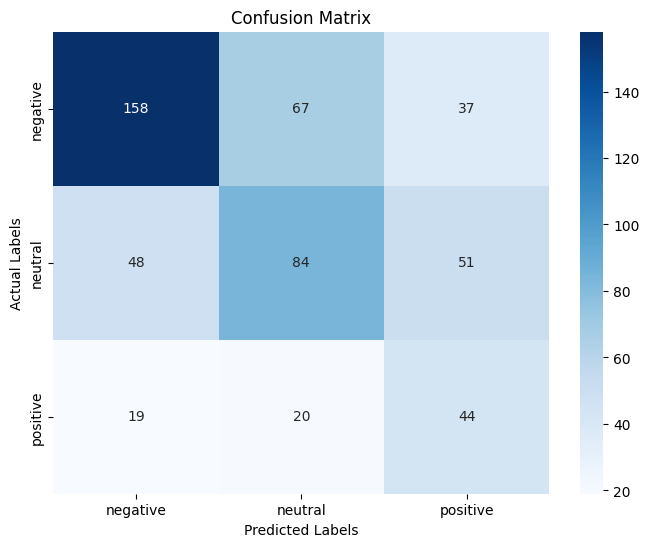

[2025-01-12 20:41:58,352][4250460751.py][line:46][INFO] Test UA: 0.530730103494946
[2025-01-12 20:41:58,353][4250460751.py][line:48][INFO] Confusion Matrix:
[2025-01-12 20:41:58,357][4250460751.py][line:49][INFO] 
          negative  neutral  positive
negative       158       67        37
neutral         48       84        51
positive        19       20        44
[2025-01-12 20:41:58,371][4250460751.py][line:53][INFO] Classification Report:
[2025-01-12 20:41:58,372][4250460751.py][line:54][INFO] 
              precision    recall  f1-score   support

    negative       0.70      0.60      0.65       262
     neutral       0.49      0.46      0.47       183
    positive       0.33      0.53      0.41        83

    accuracy                           0.54       528
   macro avg       0.51      0.53      0.51       528
weighted avg       0.57      0.54      0.55       528



In [24]:
df = pd.read_csv(CSV_FILEPATH)    
calculate_accuracy(df)